In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date, timedelta, datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_pinball_loss
from sklearn.linear_model import QuantileRegressor
from matplotlib import pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.losses import pinball_loss
from sklearn.metrics import mean_pinball_loss
import math

In [2]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
horizons = [1,2,3,4,5]

# Get data

In [3]:
current_day = datetime.today()
data = yf.download("^GDAXI", start="2000-01-01", end=current_day)["Adj Close"]
data

[*********************100%***********************]  1 of 1 completed


Date
2000-01-03     6750.759766
2000-01-04     6586.950195
2000-01-05     6502.069824
2000-01-06     6474.919922
2000-01-07     6780.959961
                  ...     
2021-12-10    15623.309570
2021-12-13    15621.719727
2021-12-14    15453.559570
2021-12-15    15476.349609
2021-12-16    15711.169922
Name: Adj Close, Length: 5573, dtype: float64

# Wavenet modeling

## Data preparation

Add all five horizons as a predictor

In [4]:
data_prep = pd.DataFrame(data)
data_prep["log_return"] = 100 * (np.log(data_prep) - np.log(data_prep.shift(1)))
for horizon in range(1,6):
    data_prep[horizon] = 100 * (np.log(data_prep["Adj Close"]) - np.log(data_prep["Adj Close"].shift(horizon)))
    data_prep[horizon] = data_prep[horizon].shift(-horizon)

#Drop CLose
data_prep.drop("Adj Close", axis = 1, inplace = True)

# Add time encoding

In [5]:
pos_enc = pd.DataFrame(index = data_prep.index)
#Year encoding
pos_enc["Year"] = pos_enc.index.year
pos_enc["n_days"] = 365
pos_enc.loc[(pos_enc["Year"]-2000)%4 ==0,"n_days"] = 366
pos_enc["Year"] = pos_enc["Year"] - pos_enc["Year"].min()
#Positional encoding
sin_encoding = np.sin(2*math.pi*pos_enc.index.dayofyear/pos_enc["n_days"])
cos_encoding = np.cos(2*math.pi*pos_enc.index.dayofyear/pos_enc["n_days"])
data_prep.insert(len(data_prep.columns), "sin_enc", sin_encoding)
data_prep.insert(len(data_prep.columns), "cos_enc", cos_encoding)
data_prep.insert(len(data_prep.columns), "Year", pos_enc["Year"])

### Create test, val, train and prediction data

Total length of data is 5530:
- Will take a year - 360 as a test set
- Whole year as validation set
- Rest as training set

In [6]:
window_size = 64
max_horizon = 5
test_size = 360
val_size = 360

pred_data = data_prep[-window_size:]

#Drop Nans
data_prep.dropna(inplace = True)

test_data = data_prep[-test_size:]
val_data = data_prep[-val_size-test_size:-test_size]
train_data = data_prep[:-val_size-test_size]

### Normalize data

In [7]:
train_mean = train_data.mean()
train_sd = train_data.std()

In [8]:
def normalize(data, mean = train_mean, sd = train_sd):
    data.loc[:,["log_return",1,2,3,4,5]] = (data.loc[:,["log_return",1,2,3,4,5]] - train_mean.loc[["log_return",1,2,3,4,5]])/train_sd.loc[["log_return",1,2,3,4,5]]
    return data

In [9]:
train_data = normalize(train_data)
val_data = normalize(val_data)
test_data = normalize(test_data)
pred_data = normalize(pred_data)

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


### Apply rolling window and get predictor

In [10]:
def convert_data(data, window_size = window_size):
    new_data = np.zeros(shape = (5, len(data),6))
    for h in horizons:
        new_data[h-1,:,0:5] = np.array(data.loc[:,["log_return", "sin_enc","cos_enc","Year", h]])
        new_data[h-1,:,5] = h-1
    window = sliding_window_view(new_data,window_size, axis = 1)
    window = np.swapaxes(window, 2,3)
    window = window.reshape(-1, window.shape[2], window.shape[3])
    features = window[:,:,0:3]
    year_emb = window[:,:,3:4]
    horizon_emb = window[:,:,-1:]
    X = [features, year_emb, horizon_emb]
    Y = window[:,-1,4:5]
    return X,Y

In [11]:
x_train, y_train = convert_data(train_data)
x_val, y_val = convert_data(val_data)
x_test, y_test = convert_data(test_data)

## Build model

In [12]:
def test_model(dropout_rate = 0.1, window_size = window_size):

    
    #Define parameters
    filters = 8
    kernel_size = 2
    dilation_rates = [2**i for i in range(6)]
    
    #Define Inputs
    input_features = Input(shape=(window_size, 3))

    #Extract embedding
    year_embedding = Input(shape=(window_size))
    year_emb = Embedding(input_dim = 22, output_dim = 2)(year_embedding)
    horizon_embedding = Input(shape=(window_size))
    horizon_emb = Embedding(input_dim = 5, output_dim = 2)(horizon_embedding)
    x = tf.concat([input_features, year_emb, horizon_emb], axis = 2)

    
    #Base layers
    for dilation in dilation_rates:
        #Preprocessing layer
        x = Conv1D(filters, 1, padding='same', activation='relu')(x) 
        #Dilated convolution
        z = Conv1D(filters, kernel_size, activation="relu", padding="causal", dilation_rate=dilation)(x)
        #Residual connection
        x = Add()([x,z])
    

    #Fully Connected Layer
    out = Conv1D(32, 1, padding = "same")(x)
    out = Dropout(dropout_rate)(out)
    out = Conv1D(1, 1, activation="linear")(out)
    out = Flatten()(out)
    out = Dense(1)(out)
    cnn = Model([input_features, year_embedding, horizon_embedding], out)
    return cnn

In [13]:
def model(dropout_rate = 0.2, window_size = window_size):

    filters = 8
    kernel_size = 2
    
    #Define Inputs
    input_features = Input(shape=(window_size, 3))

    #Extract embedding
    year_embedding = Input(shape=(window_size))
    year_emb = Embedding(input_dim = 22, output_dim = 2)(year_embedding)
    horizon_embedding = Input(shape=(window_size))
    horizon_emb = Embedding(input_dim = 5, output_dim = 2)(horizon_embedding)
    x = tf.concat([input_features, year_emb, horizon_emb], axis = 2)
    
    #Base layers
    x = Conv1D(filters, kernel_size, activation="relu", padding="causal", dilation_rate=1)(x)
    x = Conv1D(filters, kernel_size, activation="relu", padding="causal", dilation_rate=2)(x)
    x = Conv1D(filters, kernel_size, activation="relu", padding="causal", dilation_rate=4)(x)
    x = Conv1D(filters, kernel_size, activation="relu", padding="causal", dilation_rate=8)(x)
    x = Conv1D(filters, kernel_size, activation="relu", padding="causal", dilation_rate=16)(x)
    x = Conv1D(filters, kernel_size, activation="relu", padding="causal", dilation_rate=32)(x)
    
    #Fully Layer
    out = Conv1D(32, 1, padding = "same")(x)
    out = Dropout(dropout_rate)(out)
    out = Conv1D(1, 1, activation="linear")(out)
    out = Flatten()(out)
    out = Dense(1)(out)
    cnn = Model([input_features, year_embedding, horizon_embedding], out)
    return cnn

In [14]:
cnn = model()
cnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 64, 3)]      0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 64, 2)        44          input_2[0][0]                    
______________________________________________________________________________________________

In [15]:
BATCH_SIZE = 128
EPOCHS = 100
learning_rate = 0.02
optimizer = tf.keras.optimizers.Adadelta(learning_rate = learning_rate)

#Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 4, min_delta = 1e-5)

In [16]:
def train_model(model, optimizer, x_train, y_train, x_val, y_val, quantile, BATCH_SIZE = BATCH_SIZE, EPOCHS = EPOCHS, callback = callback, verbose = False):
    model.compile(optimizer = optimizer,  loss = lambda true,pred: pinball_loss(true, pred, tau = quantile))
    history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = EPOCHS, batch_size = BATCH_SIZE, shuffle=True,
        callbacks = [callback], verbose = verbose)
    return model

In [17]:
def train_all_models(x_train, y_train, x_val, y_val, quantiles = quantiles, optimizer = optimizer, batch_size = BATCH_SIZE, epochs = EPOCHS, callback = callback):
    models = dict()
    for quantile in quantiles:
        cnn = model()
        cnn = train_model(cnn, optimizer, x_train, y_train, x_val, y_val, quantile)
        print("Training finished for quantile {}".format(quantile))
        models[quantile] = cnn
    return models

In [18]:
models = train_all_models(x_train, y_train, x_val, y_val)

Training finished for quantile 0.025
Training finished for quantile 0.25
Training finished for quantile 0.5
Training finished for quantile 0.75
Training finished for quantile 0.975


## Predict new data

In [19]:
predictions = dict()
for quantile in quantiles:
    pred = models[quantile].predict(x_test)
    predictions[quantile]=pred

### Evaluate Loss

In [20]:
true_values = np.squeeze(y_test)
total_loss = 0
for quantile in quantiles:
    pred = np.squeeze(predictions[quantile])
    loss = mean_pinball_loss(true_values, pred, alpha = quantile)
    total_loss += loss
    print("Pinball Loss for quantile {}: \t {}".format(quantile, loss))
print("Pinball Loss total: {}".format(total_loss/len(quantiles)))

Pinball Loss for quantile 0.025: 	 0.05377312045887481
Pinball Loss for quantile 0.25: 	 0.21172795011382187
Pinball Loss for quantile 0.5: 	 0.23252524205161226
Pinball Loss for quantile 0.75: 	 0.20305388561686993
Pinball Loss for quantile 0.975: 	 0.0459976573217415
Pinball Loss total: 0.1494155711125841


### Test plausability

In [21]:
true_values = np.squeeze(y_test)
for quantile in quantiles:
    pred = np.squeeze(predictions[quantile])
    q_smaller = (pred >= true_values).sum()
    emp_quant = q_smaller / true_values.size
    print("Quantile met for quantile = {}: \t {} %".format(quantile, np.round(emp_quant,4)*100))

Quantile met for quantile = 0.025: 	 1.48 %
Quantile met for quantile = 0.25: 	 14.879999999999999 %
Quantile met for quantile = 0.5: 	 50.3 %
Quantile met for quantile = 0.75: 	 82.89999999999999 %
Quantile met for quantile = 0.975: 	 96.84 %


### Plot predictions

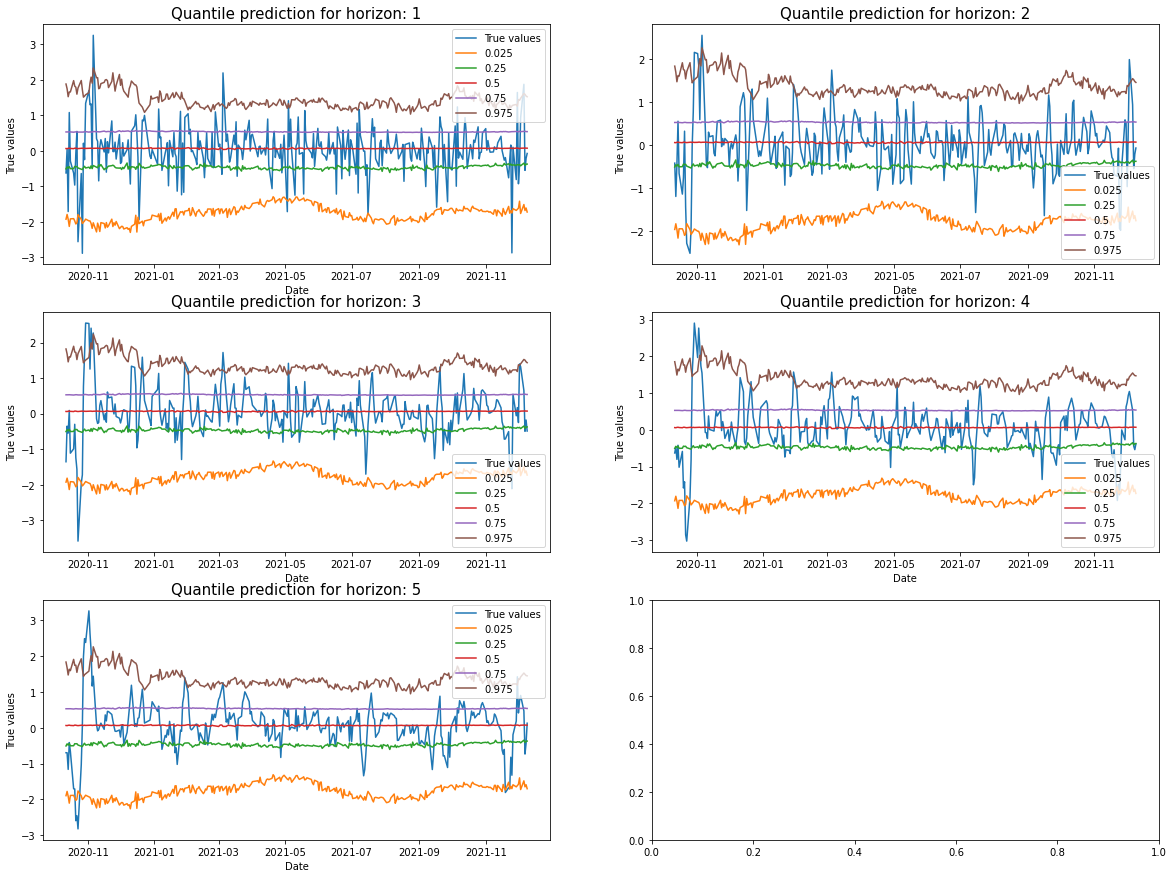

In [22]:
fig, axs = plt.subplots(3,2,figsize = (20,15))
axs = axs.ravel()

#Filter
for cnt,horizon in enumerate(horizons):
    filtering = x_test[2] == horizon-1

    true_values = y_test[filtering[:,0,:]]
    index = test_data.index[-len(true_values):]

    data_plot = pd.DataFrame(index = index, data = true_values, columns = ["True values"])

    for quantile in quantiles:
        pred = predictions[quantile]
        pred = pred[filtering[:,0,:]]
        data_plot[quantile] = pred


    sns.lineplot(x = index, y = "True values", data = data_plot, ax = axs[cnt])
    for quantile in quantiles:
        sns.lineplot(x = index, y = quantile, data = data_plot, ax = axs[cnt])
    axs[cnt].set_title("Quantile prediction for horizon: {}".format(horizon), size = 15)
    labels = ["True values",0.025, 0.25, 0.5, 0.75, 0.975]
    axs[cnt].legend(labels)

## Predict new data

In [258]:
x_train, y_train = convert_data(train_data.append(val_data))
x_pred, y_pred = convert_data(pred_data)

In [20]:
models = train_all_models(x_train, y_train, x_test, y_test)

Training finished for quantile 0.025
Training finished for quantile 0.25
Training finished for quantile 0.5
Training finished for quantile 0.75
Training finished for quantile 0.975


In [91]:
future_pred = np.zeros(shape = (5,5))
for cnt,quantile in enumerate(quantiles):
    new_pred = models[quantile].predict(x_pred)
    for horizon in horizons:
        future_pred[cnt,horizon-1] = new_pred[horizon-1,0]
#Renormalize
for h in range(5):
    future_pred[:,h] = future_pred[:,h]*train_sd[h+1] + train_mean[h+1]

In [105]:
df_horizons = [1,2,5,6,7]
final_prediction = pd.DataFrame(columns = ["forecast_date","target","horizon","q0.025","q0.25","q0.5","q0.75","q0.975"])
final_prediction["forecast_date"] = [(current_day).strftime("%Y-%m-%d") for x in df_horizons]
final_prediction["horizon"] = ["{} day".format(x) for x in df_horizons]
final_prediction["target"] = "DAX"

for cnt, quantile in enumerate(quantiles):
    final_prediction["q{}".format(quantile)] = future_pred[cnt,:]

In [106]:
final_prediction

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2021-12-02,DAX,1 day,-2.138492,-0.594457,0.129614,0.780361,2.112496
1,2021-12-02,DAX,2 day,-3.000994,-0.829362,0.188089,1.104266,2.950456
2,2021-12-02,DAX,5 day,-3.644713,-0.974375,0.238348,1.354083,3.604485
3,2021-12-02,DAX,6 day,-4.130863,-1.096742,0.278849,1.551311,4.193624
4,2021-12-02,DAX,7 day,-4.805410,-1.312234,0.310530,1.726740,4.483239


## Save final prediction

In [24]:
current_date = date.today().strftime("%Y-%m-%d")
final_prediction.to_pickle("../evaluation/predictions/single/DAX_{}".format(current_date))